### Probability of choosing the max valued feature on the trial

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

from constants.behavioral_constants import *


import scipy


In [2]:
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
num_bins = 10


In [3]:
def get_session_beh(row):
    session = row.session_name

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins=num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins=num_bins, quantize_bins=True)
    beh["session"] = session
    return beh

In [4]:
sessions = pd.read_pickle(SESSIONS_PATH)
all_beh = pd.concat(sessions.apply(get_session_beh, axis=1).values)

/src/wcst_decode/utils/behavioral_utils.py:443: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  beh = beh.groupby("BlockNumber").apply(get_block_lengths).reset_index()
/src/wcst_decode/utils/behavioral_utils.py:443: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  beh = beh.groupby("BlockNumber").app

<Axes: >

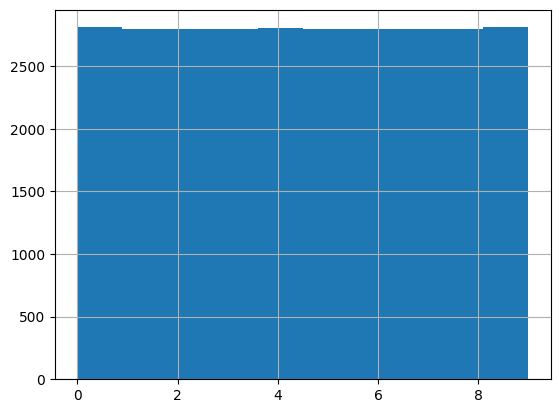

In [5]:
all_beh.MaxValueBin.hist()

In [6]:
num_features = len(FEATURES)
bins = np.arange(0, num_bins)
probs = np.empty((num_bins, num_features))

for value_bin in bins:
    print(f"evaluating bin {value_bin}")
    bin_beh = all_beh[all_beh.MaxValueBin == value_bin]
    for i, feat in enumerate(FEATURES):
        feat_max = bin_beh[bin_beh.MaxFeat == feat]
        feat_dim = FEATURE_TO_DIM[feat]
        chose_feat = feat_max[feat_max[feat_dim] == feat]
        probs[value_bin, i] = len(chose_feat) / len(feat_max)

evaluating bin 0
evaluating bin 1
evaluating bin 2
evaluating bin 3
evaluating bin 4
evaluating bin 5
evaluating bin 6
evaluating bin 7
evaluating bin 8
evaluating bin 9


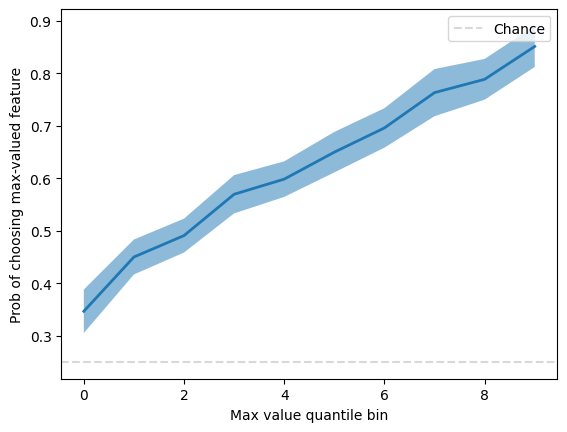

In [7]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(probs, 0, 10, 1, ax)
ax.set_ylabel("Prob of choosing max-valued feature")
ax.set_xlabel("Max value quantile bin")
ax.axhline(0.25, alpha=0.3, color='gray', linestyle='dashed', label="Chance")
ax.legend()


### Interested in: what is prob of max valued feature being the correct feature (rule) given max feature value?

In [35]:
num_features = len(FEATURES)
bins = np.arange(0, num_bins)
prob_match = np.empty(num_bins)
prob_correct = np.empty(num_bins)

for value_bin in bins:
    print(f"evaluating bin {value_bin}")
    bin_beh = all_beh[all_beh.MaxValueBin == value_bin]
    feat_cor = bin_beh[bin_beh.CurrentRule == bin_beh.MaxFeat]
    prob_match[value_bin] = len(feat_cor) / len(bin_beh)
    prob_correct[value_bin] = len(bin_beh[bin_beh.Response == "Correct"]) / len(bin_beh)

evaluating bin 0
evaluating bin 1
evaluating bin 2
evaluating bin 3
evaluating bin 4
evaluating bin 5
evaluating bin 6
evaluating bin 7
evaluating bin 8
evaluating bin 9


prob max feat is rule at 50th: 0.7906976744186046
prob subsequent trial is correct at 50th: 0.5942754919499106


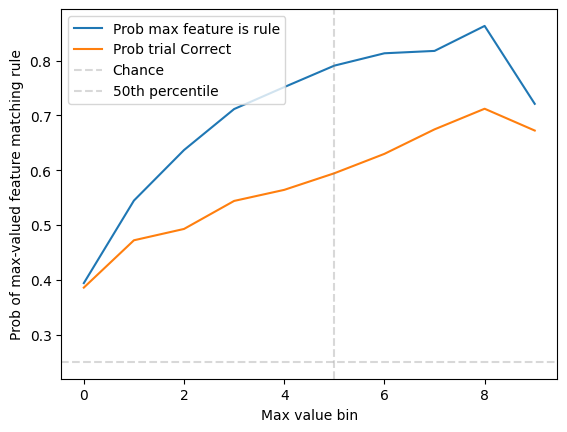

In [41]:
fig, ax = plt.subplots()
ax.plot(range(10), prob_match, label="Prob max feature is rule")
ax.plot(prob_correct, label="Prob trial Correct")
ax.set_ylabel("Prob of max-valued feature matching rule")
ax.set_xlabel("Max value bin")
ax.axhline(0.25, alpha=0.3, color='gray', linestyle='dashed', label="Chance")
ax.axvline(5, alpha=0.3, color='gray', linestyle='dashed', label="50th percentile")
ax.legend()
print(f"prob max feat is rule at 50th: {prob_match[5]}")
print(f"prob subsequent trial is correct at 50th: {prob_correct[5]}")



### Go the other way: What is the distribution of maximum values (or block positions) for trials where the max feature matches the rule, and the trial was correct? 

Text(0.5, 1.0, 'When rule matches max valued feature, and rule is chosen')

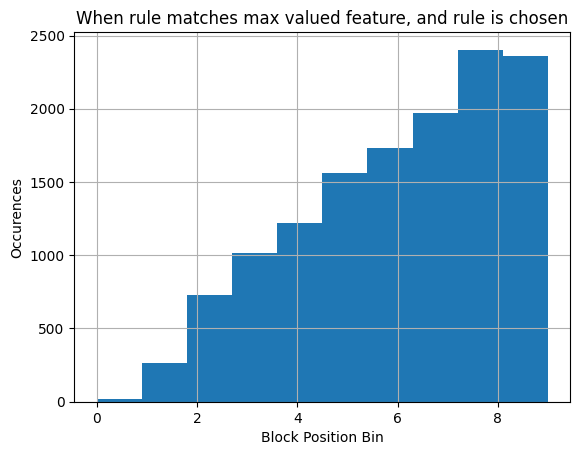

In [6]:
matches = all_beh[
    (all_beh.CurrentRule == all_beh.MaxFeat) &
    (all_beh.Response == "Correct")
]
ax = matches.BlockPositionBin.hist()
ax.set_xlabel("Block Position Bin")
ax.set_ylabel("Occurences")
ax.set_title("When rule matches max valued feature, and rule is chosen")

### Scratch

In [35]:
beh = all_beh[all_beh.session == "20180802"]
out, bins = pd.qcut(beh["MaxValue"], num_bins, labels=False, retbins=True)

In [37]:
shuf_beh = behavioral_utils.shuffle_block_rules(beh)

In [4]:
np.random.normal(1000)

1001.2136528240501

In [6]:
from sklearn.linear_model import (
    PoissonRegressor,
    LinearRegression,
    Ridge,
)
from trial_splitters.kfold_splitter import KFoldSplitter
sess_name = 20180802
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{num_bins_smooth}_smooth.pickle"

spikes_path = SESS_SPIKES_PATH
beh, frs = io_utils.load_rpe_sess_beh_and_frs(
    sess_name, 
    beh_path=SESS_BEHAVIOR_PATH, 
    fr_path=spikes_path, 
    set_indices=False,
)
# get the values
beh = behavioral_utils.get_feature_values_per_session(sess_name, beh)

agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
# hacky, but just pretend there's one timebin. 
agg["TimeBins"] = 0
mode = "FringRate"
beh = beh.set_index(["TrialNumber"])
agg = agg.set_index(["TrialNumber"])
value_cols = [feat + "Value" for feat in FEATURES]  
columns_to_flatten = []
input_columns = value_cols
splitter = KFoldSplitter(beh.index, 5, seed=42)
train, test = next(splitter)
value_reses = glm_utils.fit_glm_for_data((beh, agg), input_columns=input_columns, columns_to_flatten=columns_to_flatten, train_test_split=(train, test))

In [30]:
value_reses.sort_values(by="test_score", ascending=False)

,UnitID,TimeBins,train_score,test_score,CIRCLEValue_coef,SQUAREValue_coef,STARValue_coef,TRIANGLEValue_coef,CYANValue_coef,GREENValue_coef,MAGENTAValue_coef,YELLOWValue_coef,ESCHERValue_coef,POLKADOTValue_coef,RIPPLEValue_coef,SWIRLValue_coef
27,27,0,0.265150,0.212920,-2.508208,-2.874018,-4.888247,-5.603234,-4.959327,-4.330313,-4.225153,-4.461512,-7.078437,-8.174721,-11.491806,-8.634074
0,0,0,0.183186,0.150462,2.187712,4.937257,4.621241,0.135100,17.840978,8.115504,6.714618,13.054938,15.690536,7.599033,13.739660,7.330097
24,24,0,0.125132,0.115124,2.584781,3.192105,2.904206,3.403455,1.654061,1.791826,1.649053,1.774471,0.521628,1.584690,0.378221,1.357364
11,11,0,0.124327,0.102062,-0.994414,-0.906290,-1.084330,-1.094609,-0.753795,-0.614658,0.062501,-0.621473,-0.565482,-0.203597,-0.393696,-0.597115
9,9,0,0.081295,0.094561,3.864329,2.290624,3.415457,2.818065,-3.573045,-1.958388,1.107042,-6.321060,-10.498840,-11.896199,-15.083245,-12.674323
43,43,0,0.054808,0.068844,-0.660123,0.374793,0.847927,0.045951,2.063281,1.020573,0.784240,1.551341,2.169383,0.340207,1.191482,1.369405
12,12,0,0.052635,0.040700,-0.465167,-0.218101,-0.408910,-0.258127,0.153562,-0.046399,0.057878,0.299742,0.366952,0.703177,1.630075,0.999543
21,21,0,0.030584,0.037646,-4.020723,4.211040,-1.149668,0.476936,2.656845,-0.466922,0.339301,2.222317,-1.442381,0.841835,2.340385,-2.450228
13,13,0,0.040774,0.037612,0.024146,-0.125004,-0.505112,-0.141421,-0.488272,-0.543466,-0.273372,-0.577976,0.075092,-0.124643,-0.166552,-0.293774
22,22,0,0.033538,0.036731,0.376791,1.946503,-0.254276,-0.554124,-0.467442,-0.214182,-1.207953,0.746268,2.105022,4.311256,2.660817,1.603612


In [11]:
num_rule_blocks = beh.groupby("CurrentRule").BlockNumber.nunique()
rules_meets_condition = num_rule_blocks[num_rule_blocks >= 2]
beh[beh.CurrentRule.isin(rules_meets_condition.index)]

In [17]:
beh[beh.CurrentRule.isin(rules_meets_condition.index)]

,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,ShiftType,...,TRIANGLEValue,CYANValue,GREENValue,MAGENTAValue,YELLOWValue,ESCHERValue,POLKADOTValue,RIPPLEValue,SWIRLValue,MaxFeat
TrialNumber,,,,,,,,,,,,,,,,,,,,,
35,2,0,NaN,641,Incorrect,3.0,8,CIRCLE,CYAN,Extradim.,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,YELLOW
36,2,1,NaN,627,Incorrect,3.0,8,CIRCLE,CYAN,Extradim.,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SQUARE
37,2,2,NaN,808,Incorrect,3.0,8,CIRCLE,CYAN,Extradim.,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SWIRL
38,2,3,NaN,783,Incorrect,1.0,8,CIRCLE,CYAN,Extradim.,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TRIANGLE
39,2,4,NaN,1116,Incorrect,1.0,8,CIRCLE,CYAN,Extradim.,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TRIANGLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,54,31,NaN,4072,Correct,0.0,7,GREEN,CYAN,Intradim.,...,0.218069,-0.017239,0.540891,-0.000036,-0.131027,0.193760,0.032039,0.110023,0.196207,GREEN
1739,54,32,NaN,4429,Correct,0.0,7,GREEN,CYAN,Intradim.,...,0.245983,-0.016615,0.568805,-0.000035,-0.126286,0.186749,0.030880,0.137937,0.189108,GREEN
1740,54,33,NaN,4457,Correct,0.0,7,GREEN,CYAN,Intradim.,...,0.237082,-0.016014,0.618815,-0.000034,-0.121716,0.179992,0.029762,0.132946,0.239118,GREEN


In [16]:
rules_meets_condition.index

Index(['CIRCLE', 'CYAN', 'GREEN', 'MAGENTA', 'POLKADOT', 'RIPPLE', 'SQUARE',
       'STAR', 'SWIRL', 'TRIANGLE', 'YELLOW'],
      dtype='object', name='CurrentRule')

In [5]:
MIN_BLOCKS_PER_RULE = 2

SEED = 42
N_SPLITS = 5
from trial_splitters.kfold_splitter import KFoldSplitter

def generate_splits(row):
    session = row.session_name
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber")
    beh = behavioral_utils.get_feature_values_per_session(session, beh)
    beh = behavioral_utils.filter_blocks_by_rule_occurence(beh, MIN_BLOCKS_PER_RULE)
    beh = behavioral_utils.filter_max_feat_correct(beh)

    splitter = KFoldSplitter(beh.TrialNumber.values, N_SPLITS, SEED)
    rows = []
    for i in range(N_SPLITS):
        train, test = next(splitter)
        row = {"session": session, "split_idx": i, "train": train, "test": test}
        rows.append(row)
    return pd.DataFrame(rows)

sessions = pd.read_pickle(SESSIONS_PATH)
splits = pd.concat(sessions.apply(generate_splits, axis=1).values)

In [6]:
splits

,session,split_idx,train,test
0,20180709,0,"[59, 60, 62, 63, 64, 65, 66, 67, 72, 75, 76, 7...","[53, 69, 73, 79, 82, 83, 105, 115, 126, 150, 1..."
1,20180709,1,"[53, 59, 60, 63, 65, 67, 69, 72, 73, 75, 76, 7...","[62, 64, 66, 80, 81, 96, 97, 99, 100, 101, 104..."
2,20180709,2,"[53, 59, 62, 63, 64, 66, 67, 69, 73, 75, 76, 7...","[60, 65, 72, 121, 124, 155, 168, 198, 207, 220..."
3,20180709,3,"[53, 59, 60, 62, 64, 65, 66, 69, 72, 73, 76, 7...","[63, 67, 75, 78, 102, 103, 110, 119, 128, 130,..."
4,20180709,4,"[53, 60, 62, 63, 64, 65, 66, 67, 69, 72, 73, 7...","[59, 76, 84, 85, 117, 133, 138, 140, 141, 143,..."
...,...,...,...,...
0,20180910,0,"[36, 37, 38, 39, 42, 43, 46, 47, 51, 53, 54, 5...","[35, 50, 61, 63, 69, 71, 73, 78, 87, 90, 103, ..."
1,20180910,1,"[35, 36, 37, 39, 47, 50, 51, 53, 54, 55, 56, 6...","[38, 42, 43, 46, 62, 65, 66, 77, 97, 112, 145,..."
2,20180910,2,"[35, 36, 38, 39, 42, 43, 46, 47, 50, 54, 55, 5...","[37, 51, 53, 70, 98, 100, 154, 155, 167, 186, ..."
3,20180910,3,"[35, 36, 37, 38, 42, 43, 46, 50, 51, 53, 55, 6...","[39, 47, 54, 56, 74, 75, 76, 89, 96, 104, 106,..."
